<a href="https://colab.research.google.com/github/wangyouzhong/MLStudy/blob/master/Power_Prediction_MultiTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [718]:
import io
import pandas as pd

from google.colab import files

import numpy as np
from datetime import date, timedelta

In [719]:
TRAIN_DS_START = date(2019,2,15)
TRAIN_DS_END = date(2019,3,15)
VALIDATE_DS_START = date(2019,3,16)
VALIDATE_DS_END = date(2019,3,23)

NUM_PREVIOUS_DAYS = 1

In [720]:
# add daily sum and time bucket ratio to daily sum as features
NUM_TIME_BUCKETS = 96
START_INDEX_FEATURES = NUM_TIME_BUCKETS

def data_preprocess(df, level, train_ds_end = None):
  df.columns = ['Id', 'Date'] + [f'TB{i}' for i in range(1, NUM_TIME_BUCKETS+1)]
  df['Date'] = pd.to_datetime(df['Date']).dt.date

  # Normalize data
  if level == 3: # normalized by each node
    df = df.set_index(['Id'])

    df_groupby = df[df['Date'] <= train_ds_end].drop(columns=['Date']).groupby(['Id'])
    df_max = df_groupby.max()+1
    df_min = df_groupby.min()-1
    df = df.join(df_max, rsuffix='_max').join(df_min, rsuffix='_min').reset_index()
    for i in range(1, NUM_TIME_BUCKETS+1):
      df[f'TB{i}'] = (df[f'TB{i}'] - df[f'TB{i}_min']) / (df[f'TB{i}_max'] - df[f'TB{i}_min'])
  else: # normalized globally
    df_max = df.iloc[:,2:].max()+1
    df_min = df.iloc[:,2:].min()-1
    for i in range(1, NUM_TIME_BUCKETS+1):
      df[f'TB{i}'] = (df[f'TB{i}'] - df_min[f'TB{i}']) / (df_max[f'TB{i}'] - df_min[f'TB{i}'])

  # # Add daily sum features and time bucket ratio to daily sum
  # df['Day_Sum'] = df.apply(lambda row: np.sum(row[2:]), axis=1)
  # for i in range(1, NUM_TIME_BUCKETS+1):
  #   df[f'TB{i}_Ratio'] = df.apply(lambda row: row[f'TB{i}'] / row['Day_Sum'], axis=1)

  if level == 3:
    global START_INDEX_FEATURES
    START_INDEX_FEATURES = df.shape[1] - 2

  return df

def data_shift_days(df, days_delta):
  df['Date'] = df['Date'] + pd.Timedelta(days=days_delta)
  return df

In [721]:
# uploaded1 = files.upload()

In [722]:
df_l1 = pd.read_csv(io.BytesIO(uploaded1['131151000000000965.csv']), header=None)
df_l1 = data_preprocess(df_l1, 1).drop(columns=['Id'])
df_l1

,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,TB39,...,TB57,TB58,TB59,TB60,TB61,TB62,TB63,TB64,TB65,TB66,TB67,TB68,TB69,TB70,TB71,TB72,TB73,TB74,TB75,TB76,TB77,TB78,TB79,TB80,TB81,TB82,TB83,TB84,TB85,TB86,TB87,TB88,TB89,TB90,TB91,TB92,TB93,TB94,TB95,TB96
0,2019-01-01,0.045977,0.046655,0.044973,0.038875,0.032231,0.042813,0.047742,0.038987,0.037225,0.032163,0.044017,0.040179,0.031431,0.053578,0.035367,0.041429,0.045765,0.037578,0.041816,0.039492,0.037880,0.041314,0.047070,0.042615,0.041902,0.051098,0.040790,0.047496,0.051427,0.035981,0.036853,0.040062,0.037855,0.052617,0.049928,0.040690,0.044496,0.041735,0.047428,...,0.039104,0.046957,0.046183,0.036769,0.037380,0.040359,0.045938,0.051862,0.045029,0.040414,0.037187,0.038800,0.042371,0.046878,0.052545,0.037505,0.033909,0.042833,0.043247,0.053255,0.043669,0.041414,0.047865,0.041880,0.040959,0.039341,0.040384,0.037224,0.037005,0.054078,0.050069,0.041078,0.040113,0.039670,0.037657,0.036403,0.039816,0.039068,0.036408,0.039598
1,2019-01-02,0.043464,0.026280,0.026341,0.037036,0.028955,0.034504,0.036583,0.024640,0.033617,0.024754,0.033430,0.034279,0.026437,0.032222,0.026924,0.026857,0.032885,0.028006,0.035151,0.039615,0.021809,0.029030,0.034788,0.032623,0.033835,0.036995,0.032986,0.040366,0.038196,0.026231,0.025657,0.036887,0.034217,0.043798,0.038712,0.028969,0.033293,0.031887,0.045952,...,0.035577,0.037545,0.038518,0.037016,0.039200,0.028454,0.033476,0.043176,0.039465,0.029829,0.025445,0.032234,0.029609,0.033226,0.044553,0.034133,0.037731,0.035259,0.035306,0.031542,0.039740,0.028402,0.031515,0.036869,0.034935,0.026725,0.029819,0.033688,0.034500,0.046195,0.039961,0.040121,0.032813,0.034378,0.036498,0.026955,0.036734,0.035112,0.031281,0.036740
2,2019-01-03,0.000109,0.000113,0.000117,0.000119,0.000123,0.000128,0.000133,0.000129,0.000138,0.000138,0.000139,0.000137,0.000147,0.000145,0.000150,0.000151,0.000149,0.000150,0.000145,0.000150,0.000150,0.000147,0.000150,0.000148,0.000145,0.000138,0.000136,0.000130,0.000125,0.000124,0.000114,0.000110,0.000102,0.000092,0.000089,0.000082,0.000073,0.000069,0.000062,...,0.000054,0.000054,0.000054,0.000054,0.000055,0.000055,0.000053,0.000053,0.000053,0.000053,0.000054,0.000055,0.000055,0.000054,0.000053,0.000054,0.000052,0.000052,0.000052,0.000051,0.000052,0.000053,0.000051,0.000051,0.000050,0.000051,0.000050,0.000053,0.000053,0.000053,0.000055,0.000058,0.000068,0.000072,0.000078,0.000087,0.000087,0.000093,0.000097,0.000101
3,2019-01-04,0.035066,0.025944,0.029065,0.031459,0.026283,0.026464,0.031191,0.028416,0.031270,0.025097,0.040959,0.038704,0.017854,0.034846,0.024932,0.017855,0.030515,0.022740,0.032511,0.027236,0.022223,0.029147,0.029709,0.031808,0.033316,0.032308,0.017652,0.030101,0.032798,0.024154,0.027314,0.034578,0.028924,0.032633,0.033268,0.019147,0.029487,0.025332,0.040775,...,0.029108,0.029565,0.030432,0.031394,0.034422,0.017952,0.023789,0.029347,0.031459,0.028300,0.021134,0.035063,0.029635,0.032883,0.036268,0.025071,0.031409,0.038489,0.039484,0.035628,0.036177,0.031584,0.038712,0.032943,0.033678,0.021328,0.027331,0.020599,0.023927,0.032890,0.035913,0.030959,0.022297,0.030089,0.028207,0.031100,0.039592,0.032375,0.020032,0.035864
4,2019-01-05,0.027478,0.023993,0.028275,0.027118,0.020188,0.026099,0.026267,0.018150,0.028675,0.023315,0.023424,0.025679,0.016411,0.027567,0.018576,0.020844,0.016971,0.020063,0.033340,0.029540,0.019060,0.027119,0.032918,0.017240,0.028184,0.023675,0.019186,0.025378,0.034333,0.020961,0.014492,0.031114,0.023661,0.024942,0.021430,0.021980,0.026805,0.015089,0.025730,...,0.024263,0.021968,0.022800,0.023159,0.026425,0.016653,0.018905,0.021783,0.022604,0.025082,0.021022,0.025042,0.023565,0.027162,0.033660,0.018219,0.024610,0.024070,0.027258,0.031882,0.029123,0.023552,0.027632,0.021080,0.030541,0.020845,0.022007,0.024728,0.013910,0.035462,0.024917,0.022508,0.015179,0.028451,0.018175,0.021483,

In [723]:
# uploaded3 = files.upload()

In [724]:
df_l3 = pd.read_csv(io.BytesIO(uploaded3['L3.csv']))
df_l3 = data_preprocess(df_l3, 3, TRAIN_DS_END)
df_l3

,Id,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,...,TB57_min,TB58_min,TB59_min,TB60_min,TB61_min,TB62_min,TB63_min,TB64_min,TB65_min,TB66_min,TB67_min,TB68_min,TB69_min,TB70_min,TB71_min,TB72_min,TB73_min,TB74_min,TB75_min,TB76_min,TB77_min,TB78_min,TB79_min,TB80_min,TB81_min,TB82_min,TB83_min,TB84_min,TB85_min,TB86_min,TB87_min,TB88_min,TB89_min,TB90_min,TB91_min,TB92_min,TB93_min,TB94_min,TB95_min,TB96_min
0,139251010000000953,2019-01-01,0.207483,0.176842,0.186279,0.214309,0.193301,0.214208,0.208426,0.229050,0.170472,0.204746,0.177864,0.223525,0.186937,0.200003,0.213627,0.190826,0.185626,0.182864,0.164839,0.195323,0.147209,0.149760,0.171802,0.135701,0.180694,0.130701,0.071389,0.024984,0.004152,0.028074,0.027173,0.036439,0.054844,0.032979,0.045524,0.066656,0.085672,0.087917,...,184.176432,179.943482,177.127137,175.190525,171.771066,179.861096,189.123138,195.568212,195.765659,193.937442,198.705543,145.997571,148.877208,148.409897,144.343126,138.917253,132.280887,134.290267,138.268966,144.233556,141.589052,138.832138,137.501170,143.578787,147.044261,155.138623,168.157942,161.477838,161.238434,159.321249,160.024958,165.956953,156.720906,143.090108,143.756874,146.060011,137.041396,126.561116,119.735603,111.255813
1,139251010000000953,2019-01-02,0.093517,0.114423,0.127687,0.115658,0.148271,0.124294,0.144302,0.119222,0.173949,0.168108,0.181539,0.137028,0.189880,0.176107,0.163185,0.185218,0.176543,0.172624,0.164497,0.166308,0.181385,0.178952,0.187239,0.210000,0.213406,0.170698,0.083875,0.037145,0.039396,0.027107,0.019565,0.013260,0.018936,0.005563,0.014221,0.048614,0.061549,0.094381,...,184.176432,179.943482,177.127137,175.190525,171.771066,179.861096,189.123138,195.568212,195.765659,193.937442,198.705543,145.997571,148.877208,148.409897,144.343126,138.917253,132.280887,134.290267,138.268966,144.233556,141.589052,138.832138,137.501170,143.578787,147.044261,155.138623,168.157942,161.477838,161.238434,159.321249,160.024958,165.956953,156.720906,143.090108,143.756874,146.060011,137.041396,126.561116,119.735603,111.255813
2,139251010000000953,2019-01-03,0.084794,0.090044,0.117175,0.111291,0.134038,0.096544,0.115575,0.093270,0.138885,0.141480,0.152857,0.102372,0.161379,0.144504,0.132573,0.160731,0.149535,0.143417,0.136995,0.154091,0.160988,0.148939,0.144054,0.141508,0.055521,0.085999,0.052754,0.031330,0.054389,0.032124,0.004506,0.004497,0.004299,0.003879,0.016681,0.045930,0.056789,0.070304,...,184.176432,179.943482,177.127137,175.190525,171.771066,179.861096,189.123138,195.568212,195.765659,193.937442,198.705543,145.997571,148.877208,148.409897,144.343126,138.917253,132.280887,134.290267,138.268966,144.233556,141.589052,138.832138,137.501170,143.578787,147.044261,155.138623,168.157942,161.477838,161.238434,159.321249,160.024958,165.956953,156.720906,143.090108,143.756874,146.060011,137.041396,126.561116,119.735603,111.255813
3,139251010000000953,2019-01-04,0.096986,0.089508,0.141788,0.177710,0.172931,0.176497,0.186654,0.198408,0.169833,0.206972,0.191534,0.199615,0.194291,0.202887,0.206187,0.218865,0.208943,0.210191,0.182129,0.219943,0.178455,0.172173,0.192313,0.150007,0.126502,0.155890,0.174968,0.147173,0.143057,0.124215,0.084687,0.095139,0.092048,0.083646,0.078080,0.068289,0.035660,0.044878,...,184.176432,179.943482,177.127137,175.190525,171.771066,179.861096,189.123138,195.568212,195.765659,193.937442,198.705543,145.997571,148.877208,148.409897,144.343126,138.917253,132.280887,134.290267,138.268966,144.233556,141.589052,138.832138,137.501170,143.578787,147.044261,155.138623,168.157942,161.477838,161.238434,159.321249,160.024958,165.956953,156.720906,143.090108,143.756874,146.060011,137.041396,126.561116,119.735603,111.255813
4,139251010000000953,2019-01-05,0.006019,0.006271,0.006416,0.006632,0.006739,0.007946,0.008048,0.008242,0.007441,0.007835,0.007527,0.008838,0.007513,0.007960,0.008295,0.00762

In [725]:
def build_train_data(df1, df3, start_ds, end_ds, shift_days):
  train_data = pd.DataFrame.copy(df3[(df3['Date']>=start_ds) & (df3['Date']<=end_ds)]).set_index('Date')
  
  # Join L3 data with L1 previous days data
  for i in range(1, shift_days+1):
    df_shift = pd.DataFrame.copy(df1[(df1['Date']>=(start_ds + timedelta(days=-i))) & (df1['Date']<=(end_ds + timedelta(days=-i)))])
    df_shift = data_shift_days(df_shift, i).set_index('Date')
    train_data = train_data.join(df_shift, rsuffix=f'_d{i}_L1')
  
  # Join L3 data with L3 previous days data
  train_data = train_data.reset_index().set_index(['Date', 'Id'])
  for i in range(1, shift_days+1):
    df_shift = pd.DataFrame.copy(df3[(df3['Date']>=(start_ds + timedelta(days=-i))) & (df3['Date']<=(end_ds + timedelta(days=-i)))])
    df_shift = data_shift_days(df_shift, i).set_index(['Date', 'Id'])
    train_data = train_data.join(df_shift, rsuffix=f'_d{i}')
  
  # # Add id and week of days as one hot features
  # train_data = train_data.reset_index()
  # train_data = pd.concat(
  #     [
  #      train_data, 
  #      pd.get_dummies(train_data['Id'], prefix='Id'),
  #      pd.get_dummies(train_data.apply(lambda row: row['Date'].weekday(), axis=1), prefix='Weekday')
  #      ],axis=1).set_index(['Date', 'Id'])

  return train_data

In [726]:
train_data = build_train_data(df_l1, df_l3, TRAIN_DS_START, TRAIN_DS_END, NUM_PREVIOUS_DAYS)
train_data

TB1       TB2  ...  TB95_min_d1  TB96_min_d1
Date       Id                                      ...                          
2019-02-15 139251010000000953  0.427414  0.419421  ...   119.735603   111.255813
           139251010000001761  0.395933  0.411653  ...   147.985665   149.021149
           139251010000002373  0.352909  0.484852  ...    27.379926    26.661820
           139251010000002711  0.331918  0.335220  ...     2.907374     2.449435
           139251010000002901  0.341350  0.364158  ...     0.056108     0.053873
...                                 ...       ...  ...          ...          ...
2019-03-15 139251010000063005  0.990444  0.990879  ...    75.937547    66.323893
           139251010000063340  0.960684  0.932469  ...    35.286049    31.923862
           139251010000064677  0.992576  0.992011  ...    77.067951    78.977733
           139251010000065186  0.838808  0.830806  ...    84.020425    66.402998
           139251010000073733  0.999518  0.999489  ...  1542.431409  1468.877086

[2784 rows x 672 columns]

In [727]:
train_x, train_y = train_data.values[:,START_INDEX_FEATURES:], train_data.values[:,:NUM_TIME_BUCKETS]

In [728]:
validate_data = build_train_data(df_l1, df_l3, VALIDATE_DS_START, VALIDATE_DS_END, NUM_PREVIOUS_DAYS)
validate_x, validate_y = validate_data.values[:,START_INDEX_FEATURES:], validate_data.values[:,:NUM_TIME_BUCKETS]

In [729]:
print(train_x.shape, train_y.shape, validate_x.shape, validate_y.shape)

(2784, 384) (2784, 96) (768, 384) (768, 96)


# Build A DNN Model 

In [730]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense

In [731]:
NUM_FEATURES = train_x.shape[1]
NUM_BATCHES = 100
NUM_EPOCHS = 200

In [732]:
model = tf.keras.Sequential(
    layers = [
        tf.keras.layers.Dense(512, input_dim=NUM_FEATURES, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_TIME_BUCKETS, activation='linear'),
    ]
)

In [733]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               197120    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1

In [734]:
model.compile(optimizer='adam',loss='mae', metrics=['mae'])

In [735]:
tf.keras.backend.clear_session()

model.fit(x=train_x, y=train_y, batch_size=NUM_BATCHES, epochs = NUM_EPOCHS, validation_data = (validate_x, validate_y), shuffle=True)

Epoch 1/200
279/279 [==============================] - 1s 3ms/step - loss: 31.7478 - mae: 31.7478 - val_loss: 0.5341 - val_mae: 0.5341
Epoch 2/200
279/279 [==============================] - 1s 3ms/step - loss: 0.9245 - mae: 0.9245 - val_loss: 0.3544 - val_mae: 0.3544
Epoch 3/200
279/279 [==============================] - 1s 3ms/step - loss: 0.3059 - mae: 0.3059 - val_loss: 0.2981 - val_mae: 0.2981
Epoch 4/200
279/279 [==============================] - 1s 3ms/step - loss: 0.3016 - mae: 0.3016 - val_loss: 0.2848 - val_mae: 0.2848
Epoch 5/200
279/279 [==============================] - 1s 3ms/step - loss: 0.2210 - mae: 0.2210 - val_loss: 0.2804 - val_mae: 0.2804
Epoch 6/200
279/279 [==============================] - 1s 3ms/step - loss: 0.1944 - mae: 0.1944 - val_loss: 0.2792 - val_mae: 0.2792
Epoch 7/200
279/279 [==============================] - 1s 3ms/step - loss: 0.1861 - mae: 0.1861 - val_loss: 0.2800 - val_mae: 0.2800
Epoch 8/200
279/279 [==============================] - 1s 3ms/step 

# Evaluate the Model


In [736]:
# Model prediction
predicted_validate_y = model.predict(validate_x, batch_size = NUM_BATCHES)

df_max = np.array([validate_data[f'TB{i}_max'].values for i in range(1, NUM_TIME_BUCKETS+1)]).transpose()
df_min = np.array([validate_data[f'TB{i}_min'].values for i in range(1, NUM_TIME_BUCKETS+1)]).transpose()
denormalized_validated_y = (df_max - df_min) * validate_y + df_min
denormalized_predicted_validate_y = (df_max - df_min) * predicted_validate_y + df_min
nmae = np.mean([np.mean(np.abs(y0-y1)) / (max(y0) - min(y0)) for y0, y1 in zip(denormalized_validated_y, denormalized_predicted_validate_y)])
print(nmae)

0.15408494930148886


In [737]:
import matplotlib.pyplot as plt

def plot_validate_data(i):
  x = list(range(1, NUM_TIME_BUCKETS+1))
  y1 = denormalized_predicted_validate_y[i]
  y0 = denormalized_validated_y[i]
  print('nmae:', np.mean(np.abs(y0-y1)) / (max(y0) - min(y0)))
  plt.plot(x, y1, 'r', label = 'true data')
  plt.plot(x, y0, 'b', label = 'predicted data')
  plt.legend()
  plt.show()

nmae: 0.04384212543184737


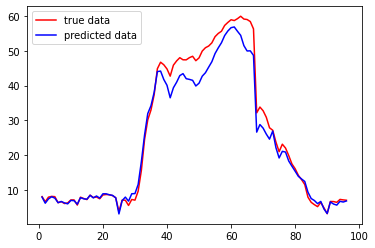

In [738]:
plot_validate_data(18)